# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.

---
## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

<img src='assets/one_hot_encoding.png' width=50%>

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

<img src='assets/lookup_matrix.png' width=50%>

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=50%>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

<img src="assets/context_drink.png" width=40%>

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.

<img src="assets/vector_distance.png" width=40%>


There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="assets/word2vec_architectures.png" width=60%>

In this implementation, we'll be using the **skip-gram architecture** because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

In [1]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [2]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [3]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [4]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [5]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

# discard some frequent words, according to the subsampling equation
# create a new list of words for training
total_count = len(int_words)
probabilities = 1 - np.sqrt(threshold / (np.array(list(word_counts.values())) / total_count))
probability_lookup = { word: prob for word, prob in zip(word_counts.keys(), probabilities) }
train_words = [word for word in int_words if random.random() > probability_lookup[word]]

print("Before: ", len(int_words))
print("After:", len(train_words))
print(train_words[:30])

(5233, 303)
Before:  16680599
After: 4628446
[5233, 1, 3133, 45, 476, 10571, 27349, 15067, 58112, 854, 58, 10712, 1324, 454, 58, 2731, 3672, 7088, 5233, 1052, 44611, 2877, 792, 200, 2621, 8983, 4147, 6437, 1, 5233]


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [6]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''

    word_range = random.randint(1, window_size)
    
    return words[max(0, idx - word_range):idx] + words[idx + 1:min(len(words), idx + 1 + word_range)]

In [7]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [4, 6]


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [9]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]


## Building the graph

Below is an approximate diagram of the general structure of our network.
<img src="assets/skip_gram_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

The idea here is to train the embedding layer weight matrix to find efficient representations for our words. We can discard the softmax layer because we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in _other_ networks we build using this dataset.

---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

<img src="assets/two_vectors.png" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [10]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model

Define and train the SkipGram model. 
> You'll need to define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

In [11]:
import torch
from torch import nn
import torch.optim as optim

In [12]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        # complete this SkipGram model
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.fc1 = nn.Linear(n_embed, n_vocab)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        return self.softmax(self.fc1(self.embed(x)))

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

**Note that, because we applied a softmax function to our model output, we are using NLLLoss** as opposed to cross entropy. This is because Softmax  in combination with NLLLoss = CrossEntropy loss .

In [15]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on: {device}")

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    print(f"Epoch {e + 1}/{epochs}")
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 32):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

Training on: cuda
two | clandestinely, calico, sumerian, cajuns, tossed
a | masterwork, boziz, favourable, gent, theta
see | mitsubishi, freire, mu, archaeology, eidyn
would | uruguayan, lancelot, quantum, fungus, xserve
zero | softpanorama, pubns, contagious, petersen, joyous
s | produce, georgy, jawed, anarchists, ascended
all | ong, whiz, southsea, homegrown, evidential
not | monosaccharides, ahijah, forbade, ikk, marcian
accepted | doonesbury, scolded, muster, esteban, diazepam
orthodox | usefully, aerobics, drowned, relinquished, ns
police | rtiges, nationalized, rhenium, antacids, escapes
event | ambracia, guelph, sicily, sampa, depressing
joseph | noin, beating, imperatoribus, genova, unsubstantiated
creation | qui, chinese, chemists, armalite, integrates
operations | wedding, shouting, filipino, mascots, indic
shown | novelas, brass, ripken, pinched, rays
...
other | haben, easel, desserts, arghun, judgment
can | sloop, trichloride, misfortunes, twigs, perennially
three | layer

often | overextended, normalisation, franklin, cumings, gru
zero | joyous, softpanorama, contagious, nanking, glace
six | pion, ranked, settlements, hira, fishman
his | obtain, sliced, aznar, brotherhoods, pusc
can | sloop, pulp, questionnaire, misfortunes, duncan
nine | larval, ikeda, corinthian, claudia, castille
over | mining, carradine, cromwell, gower, stockhausen
that | archaeologist, warranted, proverbs, obama, reporters
grand | selma, classless, vacancies, admiral, ensure
recorded | sqrta, lf, waterways, moc, mgn
resources | polycarp, stevens, glandular, colloquialisms, coinages
shown | novelas, rays, brass, ripken, pitfall
dr | languished, lactose, truthfulness, incarnate, tcm
accepted | doonesbury, scolded, muster, teach, diazepam
stage | sears, erin, landsmannschaft, heartbreak, leonov
event | ambracia, severe, guelph, depressing, sicily
...
a | boziz, masterwork, tangenziale, theta, favourable
eight | versailles, crescas, surfing, noxious, dancers
or | quart, mafia, croplan

their | nouns, essences, bounced, necromancy, mong
or | quart, mafia, cropland, mchugh, fork
than | okresy, zwolle, searchable, peg, constantly
known | digraph, democratic, wings, cubits, passim
also | personage, niv, slackware, layla, flamboyant
however | suspicion, resentments, gesture, forwarded, amistad
are | daniell, theists, religiosity, hatfield, marilyn
used | egotistical, pavilion, bw, chrysler, harrison
mean | tackle, tampering, studd, insignificant, contended
defense | ayla, milford, dalmatia, stockwell, predict
powers | imitation, caltech, misfits, ingersoll, eithne
pre | newstead, mms, allotropic, forbidden, commentary
event | ambracia, guelph, severe, sampled, draper
versions | vint, zwickau, arkham, aonb, turbines
paris | meatball, jolley, philoctetes, discussing, creasy
ocean | admission, map, wav, willamette, bunghole
...
in | weary, user, dmitry, misanthropy, nocturne
over | demonstration, nasl, conciliatory, stockhausen, carradine
that | warranted, auction, cept, pro

its | timespan, bb, mansfield, urbino, carom
two | zero, nine, one, american, gregor
i | razed, literature, twos, anthropologist, concealing
been | freer, splines, seizing, holberg, chi
zero | nine, two, one, eight, four
seven | one, six, nine, four, three
there | swordsmanship, virial, capturing, preface, idolatrous
while | gacy, withdrawal, pahlavi, college, tobruk
applied | website, chronicling, wealthier, distract, causality
articles | kite, judeo, dishonest, domitius, daybreak
powers | imitation, eithne, caltech, enable, ingersoll
behind | shirelles, participant, mcnamara, balhae, richelieu
file | expandability, blissymbols, homeowners, limes, hooft
joseph | unsubstantiated, noin, faso, genova, borrelly
bible | sisak, picket, striving, disagreement, kindia
lived | tedious, conservatism, cosmonauts, interludes, hepatitis
...
people | seperated, unsound, collimated, bestial, shakespeare
than | okresy, zwolle, lok, frictional, flared
had | pious, luisa, reverting, autobahn, new
many 

s | one, the, eight, of, on
can | kang, ugaritic, deployments, aino, hypertrophic
system | mcvie, vehicle, khanty, adelphi, appointments
one | eight, two, three, five, nine
four | eight, three, two, seven, zero
such | lutes, phagspa, nikolaevich, metal, joliet
seven | nine, four, zero, one, eight
from | and, gwent, mixture, khanate, derisively
magazine | genuineness, leo, solstices, joanna, sculptures
discovered | degas, recasting, rampant, nonspecific, gw
mainly | farragut, african, celera, browed, visionaries
construction | tl, coulsdon, yamamoto, poststructuralism, deepwater
ocean | admission, willamette, islamiyah, crux, wav
proposed | orf, logbook, kremvax, martyrology, qaddafi
brother | icarus, meigs, lycaeus, sackville, reservists
grand | admiral, november, selma, packers, harmonious
...
united | minneapolis, warlords, of, akbar, jettison
but | bicoid, disliked, hulme, equiv, subsonic
s | one, of, for, eight, the
eight | one, four, two, six, nine
for | the, a, s, in, of
about | 

its | musician, martha, autoconfiguration, chau, calm
new | tackled, zadok, io, lightly, hatch
b | c, eight, three, iz, j
were | earned, world, eclectic, synapomorphies, by
up | annually, wav, sharif, qattara, macrolide
a | on, one, s, for, to
nine | four, three, zero, one, american
seven | four, five, one, nine, three
mainly | african, farragut, tzar, homophony, visionaries
engineering | mechanical, coma, tensor, isaias, runoff
versions | octavius, vint, original, pattern, stfm
placed | longing, chihuly, gorda, budge, three
know | shoestring, odes, compile, noblesse, detriment
running | concepci, inquired, charismatics, centimeter, bb
units | finishing, force, prisoners, galtieri, valcourt
applications | for, divergences, epinephrine, naxos, expanding
...
d | malayan, eight, hariri, dendrite, barclay
two | nine, four, one, five, zero
there | idolatrous, swordsmanship, nonlinear, crenshaw, textbook
use | dissolving, view, styles, realizes, kohoutek
i | you, of, true, hinckley, bedi
a |

there | idolatrous, meio, poetess, lodger, miracles
most | legates, languages, from, europe, like
world | gravel, dyslexic, mucosa, was, curing
two | zero, nine, three, five, four
united | east, british, scotland, warlords, minneapolis
new | lightly, zadok, aldine, osijek, heterosexism
it | two, made, we, other, lignin
but | that, however, making, disliked, accelerate
scale | landslides, cardiopulmonary, pitch, note, class
freedom | banning, lint, vijayanagara, offices, diffeomorphism
defense | sanfl, stockwell, pilots, bases, milford
placed | gorda, cans, kaveri, cypher, jess
bill | york, retroactively, raymond, mandriva, records
units | finishing, sp, prisoners, range, spectacular
animals | species, proteins, that, invertebrates, fortuna
test | capitalize, for, prod, chromatically, senatorial
...
who | immanence, seagull, nation, pig, breisgau
united | british, east, warlords, scotland, minneapolis
where | storms, to, almenr, an, following
five | one, seven, zero, three, two
between 

is | a, are, the, to, of
th | history, the, saint, czech, offshore
three | five, two, zero, four, seven
with | to, hemorrhagic, called, which, press
a | the, on, to, is, and
was | the, his, restored, role, prince
where | are, francorum, storms, a, to
up | annually, eliminative, mergesort, petals, ponce
smith | yokosuka, amygdalin, tale, mctell, managerial
applied | zarqawi, tallow, simply, halfback, scaled
notes | economics, olympiads, ricin, roadie, assembly
institute | blake, prelate, waterline, ailes, edward
behind | mcnamara, turns, noin, batter, much
creation | opposition, abbahu, chinese, eck, greenstone
pope | rome, mcgee, chaplain, documentary, predication
http | www, org, essentialist, myra, html
...
if | we, can, let, commutative, kr
between | area, along, desert, from, jackpot
his | son, him, he, mother, william
this | is, to, known, mutants, more
during | children, in, deaths, laysan, seven
world | league, was, site, mertens, hosting
about | footnotes, months, famous, eight

an | as, five, to, these, a
there | to, a, sugar, roswell, from
when | hand, perhaps, go, with, if
which | reaction, used, engineer, volume, the
united | vietnam, tobago, granted, ireland, nacional
these | or, an, rule, thin, different
many | gilgal, intravenously, number, applications, languages
as | of, the, are, by, to
derived | esso, harmless, sundays, haudenosaunee, identified
arts | school, appeared, shanghai, education, recalls
question | regression, compares, consequence, billboards, concerning
operating | distributed, rms, software, artificial, apple
accepted | few, esteban, teos, uranian, have
except | swollen, abendana, yitzhak, toothless, phipps
magazine | yonkers, music, warrant, gilchrist, us
powers | defence, ronson, power, afterward, octavian
...
at | back, four, eight, after, seven
had | he, eight, his, in, first
years | three, six, age, four, two
known | of, used, as, comes, broken
which | used, volume, with, reaction, also
it | a, can, for, commonly, as
not | true, s

eight | one, six, three, nine, five
so | be, consequence, take, should, merino
years | age, at, poverty, toledo, last
all | have, or, are, from, assigned
where | leyland, arises, jim, offence, lith
system | systems, degree, supports, file, pdf
two | three, one, seven, six, eight
six | eight, nine, five, one, three
cost | costs, weapon, imd, cad, hydrate
units | speed, aircraft, mm, finishing, four
pope | rome, bishops, leo, emperor, historians
know | do, you, man, creatures, carols
scale | coordination, measuring, cm, cardiopulmonary, beans
event | thought, rumble, accounts, known, reminds
paris | jolley, king, charles, duke, train
governor | minister, appointed, elected, mayfield, karts
...
be | by, can, how, are, so
united | states, national, legislative, british, tobago
at | wound, march, five, constellations, bay
d | one, eight, de, r, c
history | part, article, online, academic, briefing
are | is, example, the, which, unlike
other | are, as, hot, canyon, produce
it | the, and, by,

their | where, holding, rear, player, over
when | father, went, me, after, to
war | forces, military, army, abolished, crisis
most | brain, some, of, part, close
will | be, must, that, who, result
has | about, in, two, zero, also
b | c, one, m, nine, d
i | n, p, k, v, m
instance | infuse, schala, dall, normalizing, fascinating
operating | ram, system, unix, run, systems
award | nine, film, starred, steve, zero
creation | technologies, text, of, fact, theories
road | county, town, park, memorable, queen
professional | schools, cleveland, education, nfl, college
defense | training, losses, team, pro, president
event | skepticism, actually, god, qualities, likely
...
new | s, nine, one, press, york
these | have, such, be, or, definition
nine | one, six, two, four, zero
other | are, arguments, as, style, culture
history | of, site, article, see, encyclopedia
over | to, when, end, their, on
were | regiments, attack, the, had, attempt
state | propounding, between, responsibility, member, ris

is | refer, not, a, other, see
will | must, be, of, then, disambiguation
has | note, mostly, same, children, is
a | used, may, if, for, an
up | be, of, death, his, result
s | nine, one, four, five, from
at | ii, battle, by, after, had
they | them, were, that, blind, would
freedom | social, movements, justify, evil, advocates
instance | startrek, triangulation, o, variables, jtf
road | tower, railway, county, bridge, london
consists | encompasses, nt, redirection, are, vary
ice | sung, bottom, erick, rim, arch
proposed | statistical, wanted, scipio, achieved, jailed
bible | testament, jesus, gospels, christ, hebrew
recorded | song, dylan, tamer, entitled, album
...
during | army, day, empire, destroyed, war
however | overcome, identified, with, yet, they
zero | nine, two, six, three, eight
people | far, with, well, previously, east
the | war, some, with, in, near
use | dialect, prefix, prevent, meaning, widespread
but | others, to, course, some, that
th | century, the, empire, rd, five


at | s, four, in, eight, nine
b | x, e, n, j, r
nine | five, three, one, four, two
with | an, a, it, as, the
th | century, near, francois, rd, bc
been | religion, from, was, literature, warrant
one | nine, seven, four, three, five
an | a, with, current, the, example
shows | room, anime, tv, edited, blue
applications | software, algorithm, cpu, oriented, processing
joseph | nine, by, in, henry, opposed
cost | manufacturers, supply, money, cheaper, consumers
marriage | catholic, biblical, composers, speeches, she
numerous | found, victims, medieval, beginning, lecter
articles | publications, online, edition, wiki, writers
engineering | design, technology, electrical, designed, computer
...
it | by, is, then, in, with
six | seven, eight, two, nine, five
with | an, and, many, types, by
s | at, eight, zero, three, by
american | canadian, united, native, americans, french
only | than, called, spread, via, form
they | place, over, unlikely, teres, islam
was | s, to, been, he, by
mainly | euro

be | same, can, entirely, vertically, does
years | last, female, four, eight, days
can | solution, simple, used, be, software
were | love, his, to, took, letters
they | when, with, does, places, lies
if | you, must, possible, say, can
nine | one, seven, zero, eight, six
will | that, if, win, goals, off
freedom | rights, software, guaranteed, restrict, free
bill | herbert, received, bowie, minister, brother
issue | elections, legislative, programmed, deathbed, propose
stage | musical, walk, actors, cancer, kiss
liberal | parties, government, liberals, party, political
engineering | technology, computer, designing, electrical, education
road | located, highway, bridge, km, buildings
governor | chief, president, minister, secretary, independence
...
their | children, young, have, practice, to
between | eskimo, baltic, outside, farther, nationalism
into | most, holes, the, have, burning
had | his, her, would, soviet, he
as | with, many, following, surrounding, is
in | the, and, including, 

had | his, he, remained, younger, king
where | y, two, on, if, n
if | is, i, objects, that, possible
first | two, in, eight, by, mathematician
system | interface, directory, operating, unix, systems
were | capital, over, spanish, mid, army
not | that, our, believe, objects, if
was | august, destroyed, named, rivalry, battle
pre | from, as, gets, example, all
troops | allied, forces, rebels, brigade, campaign
bill | herbert, later, poet, minister, symbology
articles | http, wiki, online, publications, links
versions | version, disk, format, read, microsoft
brother | he, her, she, elevated, wife
arts | york, grey, community, refined, shanghai
applied | scientific, context, keeshonden, implicitly, of
...
it | civilization, be, fe, may, only
th | nine, roman, zero, france, six
up | attack, bed, being, and, but
would | rather, because, adonai, render, which
was | august, battle, destroyed, named, edward
see | of, in, also, on, many
if | i, is, then, result, follows
some | meaning, tradition

in | is, a, to, was, as
was | th, charles, his, by, history
or | is, of, to, the, than
for | e, a, that, to, as
at | the, died, was, three, a
will | need, behind, like, speed, what
one | nine, six, five, two, zero
used | also, are, examples, can, contains
additional | teenager, computers, retaking, normal, kv
articles | online, http, wiki, edition, website
file | files, users, server, programming, interface
bible | orthodox, christian, testament, translation, theologians
account | isbn, emission, by, century, how
bbc | television, www, broadcast, news, january
engine | engines, powered, computers, designed, automobile
assembly | prime, constitution, minister, representatives, elections
...
used | are, forms, also, an, can
was | charles, history, edward, early, later
the | is, which, be, an, of
to | and, have, but, it, or
had | emperor, leader, him, victor, was
at | and, three, the, america, an
there | about, few, total, that, be
only | an, this, have, to, using
channel | broadcasting, 

between | the, used, merely, event, in
it | only, most, like, to, known
no | with, act, footpaths, rule, settlement
have | as, around, forms, distinguish, usually
with | and, greek, used, not, in
are | is, and, instead, contains, red
i | me, go, man, love, philosopher
at | one, nine, half, october, referred
centre | entertainment, town, crossed, afoul, construction
magazine | film, george, chris, editors, award
shown | represents, counterparts, example, sources, restricted
grand | queen, architect, htm, auto, hippocrates
taking | serious, hour, if, custodian, worst
hold | day, give, permission, henchmen, himself
mainly | villages, also, religions, norse, ancient
stage | nobel, sparked, ois, prize, living
...
d | la, m, one, carl, k
four | one, nine, eight, five, seven
after | in, emperor, had, beginning, king
from | ruled, off, now, valley, of
five | seven, zero, two, four, one
of | and, by, one, the, attempts
only | it, number, armies, non, titles
see | www, article, ph, times, proto


some | sacred, science, such, practice, modern
when | very, onto, at, three, conquered
it | to, only, even, the, practice
can | cases, or, does, require, allows
during | of, the, son, was, invasion
than | has, greater, meters, less, license
see | of, c, the, zero, three
years | five, days, three, conquered, th
mathematics | logic, analysis, sciences, mathematical, geometric
heavy | metal, production, characteristics, shock, s
paris | du, eight, university, la, he
mainly | mountainous, india, predominantly, sikh, dominated
orthodox | church, catholic, churches, christianity, faith
arts | college, theatre, university, buildings, museum
articles | comprehensive, encyclopedia, wiki, asiatic, wikipedia
shown | note, vowels, names, cubes, vowel
...
on | the, two, mr, made, just
as | the, nation, of, becomes, became
is | are, but, for, more, gives
it | to, similar, side, practice, will
zero | two, six, nine, five, four
war | attack, signed, forces, s, battle
has | can, when, be, these, doing


history | list, origins, on, stanford, modern
it | energy, possible, is, version, capability
not | as, in, is, divine, itself
people | speakers, central, population, demographics, ethnic
i | t, frac, am, q, want
with | and, part, is, in, little
often | means, phonemes, carmichael, or, approach
is | as, an, a, combination, or
dr | isbn, mike, andy, gary, actor
powers | government, remained, arab, conflict, sovereign
consists | in, generally, situated, level, cleaning
engine | engines, combustion, powered, capacity, cylinder
award | awards, academy, fiction, best, magazine
units | two, mechanical, kilogram, per, si
marriage | father, her, his, sexual, brother
brother | daughter, her, he, him, father
...
i | t, am, me, frac, something
if | then, given, examples, that, has
united | constitution, commonwealth, representatives, indonesia, nations
are | in, a, e, example, h
state | government, representatives, towns, legislature, town
these | least, first, base, also, high
his | king, henry, 

people | that, american, writer, states, husband
with | in, from, the, is, on
was | eight, the, six, english, four
which | the, near, that, six, by
than | feet, parts, cm, singular, holiday
is | by, that, the, in, of
american | one, eight, six, nine, actor
six | eight, one, zero, four, three
orthodox | jewish, churches, judaism, christianity, orthodoxy
dr | nine, isbn, five, actor, two
heavy | steel, explosives, generally, severely, success
cost | reconnaissance, customers, manufacturing, disadvantages, rates
bill | vote, executive, sir, herbert, dick
proposed | motion, laws, formation, conservative, each
freedom | god, british, writings, troops, enforcing
operating | windows, graphical, server, unix, software
...
or | recipient, medicine, sex, actress, of
many | who, between, most, written, of
states | of, state, kingdom, united, americans
known | s, four, between, be, and
and | eight, one, of, nine, john
as | the, eight, in, s, for
see | also, external, and, article, s
they | appears

known | same, in, by, term, following
in | the, his, as, three, nine
some | rate, solid, this, approach, of
zero | four, five, nine, two, three
who | his, the, have, made, to
two | zero, four, nine, seven, one
they | be, or, so, trying, that
this | form, day, days, some, judgement
cost | office, s, back, policy, aircraft
active | genetics, killers, rita, atomic, formation
square | meters, adjacent, space, floors, below
applications | architecture, application, server, desktop, java
gold | copper, bronze, silver, metals, aluminium
prince | daughter, duke, succeeded, regent, son
hit | blues, album, hop, success, band
rise | countries, some, growth, increasing, roman
...
its | may, and, was, that, of
system | data, employ, components, may, core
at | the, of, is, seven, located
an | the, of, to, had, s
d | b, one, nine, writer, french
called | they, had, may, the, number
years | s, well, later, one, seven
when | later, was, had, the, that
experience | advertising, informed, travel, happens

see | and, chinese, yin, article, spoken
between | of, rather, these, used, respectively
states | united, usa, british, including, in
system | non, a, that, controls, core
a | the, of, an, and, as
which | with, a, and, the, found
most | much, history, non, available, some
its | council, and, company, is, as
mean | be, correct, differs, generalized, q
active | the, uk, atomic, in, nine
universe | galaxy, evil, cosmology, star, cosmic
alternative | world, different, mean, of, between
shows | ever, upcoming, art, good, starred
resources | creating, environmental, imports, group, industry
hold | exist, sin, strict, should, non
quite | rather, different, both, forward, thus
...
zero | two, eight, six, four, three
history | writers, dedicated, legend, considered, encyclopedia
an | a, although, is, in, the
world | international, greatly, japan, new, writer
see | literature, links, case, faq, also
first | at, one, external, on, uk
that | a, is, the, case, many
which | with, the, a, found, as
f

that | while, could, with, a, to
where | having, e, ends, river, called
called | is, a, in, as, directions
is | are, be, means, small, by
state | central, municipal, the, of, democratic
two | zero, four, seven, five, six
use | or, to, words, some, make
states | united, british, of, usa, rights
egypt | israel, egyptian, persian, jerusalem, persia
numerous | survive, fishing, coastal, increased, kyoto
assembly | elections, seats, parliamentary, parliament, representatives
road | east, suburban, route, place, urban
mean | language, every, programming, mentioned, j
woman | birth, children, her, married, noun
award | awards, achievement, academy, best, winning
bible | hebrew, hebrews, scriptures, torah, encyclopedia
...
known | used, three, zero, be, the
if | is, does, you, be, itself
who | he, her, to, was, with
states | united, nations, british, usa, north
that | existence, be, similar, so, to
three | zero, nine, seven, one, eight
had | the, came, he, and, korean
use | or, some, used, let

state | municipal, federal, minister, louisiana, executive
would | had, seems, which, him, and
no | have, in, is, either, may
up | they, stability, just, orange, files
be | could, rest, initial, this, any
used | use, the, intended, uses, devices
years | female, male, live, population, ratio
an | s, the, p, returned, international
professional | football, hockey, sports, voted, basketball
assembly | held, seats, elections, elected, vote
prince | queen, regent, appointed, hereditary, king
cost | poor, rates, most, sold, consumed
applied | analysis, elimination, h, opening, analyse
recorded | recordings, band, hot, frost, temperatures
quite | single, cases, sherborne, piece, prefer
hold | choose, held, prayers, opposed, seat
...
after | was, suffered, had, died, of
will | no, or, even, the, not
were | the, but, israel, defeated, seven
has | and, popular, but, which, that
called | known, navigable, outer, of, covered
may | no, of, drawn, s, had
so | sure, which, you, what, are
often | of, 

can | cannot, are, patterns, examples, element
about | three, them, s, and, preliminary
is | a, are, tree, f, as
by | eight, this, s, for, and
on | first, of, the, two, in
zero | seven, three, two, five, four
war | army, soviet, troops, siege, armed
often | a, patterns, though, always, alternative
something | if, excessive, nothing, him, ever
marriage | emperor, younger, her, married, child
articles | wiki, resources, languages, literature, reviews
recorded | album, biggest, recordings, mike, band
rise | the, region, to, than, few
placed | were, over, rendered, probably, extensive
joseph | john, born, singer, saint, james
universe | golden, planets, cosmology, superhero, heroes
...
over | and, versions, runways, use, total
be | that, decision, only, if, wish
would | sell, only, declined, continue, output
but | exclusively, played, regulation, they, although
are | they, is, and, may, can
who | god, friend, political, her, husband
seven | eight, two, one, five, nine
the | in, just, and, 

also | of, and, created, in, relating
who | to, god, and, as, of
war | and, by, the, as, soviet
four | six, one, seven, two, nine
into | portugal, the, every, a, two
often | of, and, frequently, alternative, kind
were | europe, as, ruled, islamic, and
two | six, one, zero, seven, five
dr | seven, jr, jo, bernard, american
powers | france, administrative, montenegro, sovereignty, great
account | meaning, to, traces, reveals, hence
magazine | lyrics, titled, film, earned, imdb
liberal | denominations, beliefs, conservative, dean, cultural
bible | jewish, hebrews, theology, scriptures, christian
engineering | model, software, nucleus, electrical, atomic
freedom | policies, murray, liberty, rights, economic
...
war | and, attacked, by, soviet, to
at | the, attend, his, festival, of
seven | two, zero, five, four, eight
in | and, to, are, the, of
about | collection, could, in, by, external
while | propositional, they, the, visiting, example
states | state, united, legislature, nations, law
s

see | the, and, out, been, main
other | and, are, some, theory, more
d | eight, one, politician, six, writer
will | for, change, where, sometimes, example
most | spoken, the, addition, spread, mostly
often | means, either, are, known, kind
his | he, wife, she, father, john
if | theorem, let, want, exactly, f
woman | daughter, birth, married, sex, she
operations | assistance, naval, mil, facility, implementation
san | francisco, juan, luis, diego, portugal
troops | defeated, occupied, army, command, defeat
mainly | primarily, marked, ethnically, spoken, small
governor | executive, law, officer, attorney, minister
lived | near, emperor, franco, which, revenge
joseph | d, german, b, physicist, american
...
more | from, characteristic, form, generally, and
their | from, time, to, larger, both
of | and, to, in, as, a
a | is, in, to, and, of
while | a, but, as, family, to
years | three, birth, four, female, tribute
are | and, a, to, but, present
first | three, six, james, century, history
fr

d | b, laureate, writer, politician, poet
with | as, the, called, of, for
may | occurrence, in, are, phrase, been
who | his, advice, s, in, son
than | zero, built, more, as, to
one | zero, four, eight, six, nine
nine | one, four, eight, actor, six
not | but, even, so, therefore, they
institute | university, sciences, college, school, eight
joseph | d, b, statesman, physicist, actor
event | onstage, australia, los, cross, sport
animals | organisms, food, eggs, fish, animal
marriage | married, younger, husband, divorce, child
instance | common, represent, type, as, convert
stage | the, features, known, perform, s
hold | towards, years, retirement, described, main
...
other | a, most, are, always, more
one | nine, four, eight, five, three
use | written, most, sometimes, dozen, form
for | a, it, first, and, any
new | york, illinois, columbia, one, nine
seven | nine, four, eight, five, one
some | or, as, that, been, relationships
d | politician, b, writer, one, laureate
instance | as, lette

eight | seven, one, six, four, three
six | eight, four, one, three, five
many | baptists, linguistic, political, leadership, structured
all | or, affairs, of, but, certain
their | them, be, have, to, they
by | of, eight, to, with, one
zero | three, two, six, one, eight
this | possible, the, in, a, from
stage | phases, type, orbit, two, screening
versions | users, mb, version, mac, windows
engine | engines, weight, equipment, piston, propulsion
issue | yang, jewish, though, arab, reagan
pressure | the, tube, oxygen, internal, liquid
paris | de, du, des, le, ix
joseph | statesman, german, poet, williams, gabriel
placed | belonging, minutes, insertion, least, was
...
there | been, for, in, surrounding, confusion
people | with, and, eastern, of, from
three | two, six, zero, seven, four
he | his, died, had, of, wife
these | a, as, for, other, of
used | be, use, classification, bases, and
time | of, a, for, in, seven
zero | three, two, seven, one, six
pope | gregory, papal, iv, st, xii
grand

used | the, combinations, as, products, is
most | the, article, and, in, of
up | the, an, through, who, s
first | runner, th, s, the, an
called | a, is, used, or, the
other | are, used, or, of, the
state | thirteen, brandenburg, administrative, parliament, proceedings
in | the, s, from, of, and
brother | son, eight, sons, four, the
shown | represents, circulation, set, of, been
prince | ruled, son, crown, regent, emperor
woman | sex, children, female, fertility, birth
applied | taught, association, topics, a, thermodynamics
versions | users, release, basic, microsoft, mb
know | god, says, you, me, statement
stage | features, through, type, back, focused
...
or | is, the, may, formal, fingers
they | their, as, that, order, to
into | from, type, the, a, water
with | in, just, and, the, from
an | all, the, up, credited, within
has | nevertheless, by, history, and, a
three | one, zero, four, six, two
also | is, disambiguation, a, by, the
articles | org, com, wikipedia, page, manual
pope | 

an | and, a, of, is, that
use | usually, scale, particular, can, typically
s | which, to, two, and, a
such | a, major, of, involves, uses
they | as, of, the, them, make
often | commonly, used, forms, can, called
have | as, the, a, particular, them
more | means, weight, attempts, portion, reducing
frac | sqrt, cdot, x, right, cos
dr | actress, two, the, zero, one
numerous | it, of, which, story, see
prince | queen, regent, son, writer, edward
liberal | party, liberals, conservative, labour, parliamentary
brother | nicholas, son, assassinated, alexander, him
proposed | claimed, mp, analysis, locations, particularly
quite | forms, particularly, parts, although, an
...
and | the, in, an, of, one
to | in, for, s, by, the
over | either, but, revival, bollywood, are
by | the, which, in, of, zero
known | of, the, one, st, was
on | the, of, as, for, a
of | the, as, in, see, known
their | the, as, most, forced, of
applications | interface, basic, portable, linux, unix
engineering | application, 

use | rare, commonly, of, uses, decimal
time | possible, while, their, end, results
world | times, recognized, other, war, tradition
would | not, promise, essentially, refused, party
but | some, being, wife, re, a
many | some, of, which, are, similar
the | by, of, and, a, described
and | the, in, of, by, a
older | household, freebsd, median, harald, well
engineering | studied, anatomy, computers, development, electronics
mainly | portuguese, argentine, country, european, high
joseph | statesman, poet, richard, edward, sir
additional | diagram, specially, chest, atm, furthermore
applied | taught, renaissance, hamburg, religion, society
operations | naval, operation, forces, closure, base
construction | railway, dedicated, architectural, extending, steel
...
used | combinations, the, with, blue, batteries
during | in, broke, season, moroccan, broken
when | the, himself, hospital, a, will
in | the, and, to, with, which
into | water, the, valley, where, bed
over | the, areas, spread, zero,

of | the, and, is, a, in
used | is, the, play, a, of
zero | one, three, five, nine, seven
are | some, the, that, in, is
between | the, and, less, an, are
war | invaded, army, arab, forces, command
in | and, the, by, of, are
that | are, not, the, is, number
taking | genders, effective, and, whom, muhammad
grand | south, from, jean, the, village
orthodox | church, christians, apostolic, catholic, denominations
articles | wiki, article, links, org, comprehensive
accepted | body, a, of, in, the
writers | singers, literature, poets, romantic, wrote
running | platform, windows, mhz, crowd, front
file | code, windows, extension, microsoft, operating
...
a | of, in, by, and, an
war | army, battles, battle, command, invaded
he | him, his, fled, gave, died
that | are, be, when, out, not
while | and, are, to, limited, among
was | first, ii, his, became, years
often | an, common, other, modern, large
at | an, seven, passing, virginia, in
applications | code, computers, desktop, hardware, applicati

war | ii, invasions, cuban, wwii, battle
five | eight, seven, one, zero, four
are | such, so, in, example, the
nine | one, seven, three, eight, richard
world | western, has, occupation, heritage, consistent
have | to, the, part, from, or
state | states, of, it, the, in
this | a, in, to, and, or
except | speed, fairly, pole, ski, let
pressure | liquid, heat, engine, gas, drops
engineering | reserve, engineers, training, architectural, royal
test | airways, apple, manufacturer, based, games
woman | fertility, sexually, son, marriage, male
units | consisted, unit, battalion, charge, cavalry
shown | episode, black, that, raf, bbc
creation | in, of, such, adaptations, and
...
state | new, states, province, china, power
will | you, can, amount, takes, expect
used | first, a, example, in, lisp
only | or, that, from, become, therefore
of | and, who, two, part, in
his | him, vienna, he, and, constantine
their | from, play, who, indigenous, never
after | he, days, succeeded, five, one
assembly |

see | two, references, the, maps, m
while | of, by, was, which, the
zero | two, four, six, five, seven
state | groups, new, of, people, seven
in | by, led, nine, on, the
more | for, than, to, even, the
not | last, any, even, he, includes
b | nine, c, six, one, two
units | battalion, cavalry, artillery, constants, unit
paris | france, dei, de, piano, orchestra
san | francisco, diego, de, california, los
consists | can, is, system, which, representation
taking | the, when, but, by, father
report | commission, conducted, bureau, investigation, journalist
brother | son, wife, his, throne, married
account | devoted, doubt, that, cosmology, special
...
new | york, nine, press, five, by
for | or, both, the, on, two
one | eight, five, three, seven, six
only | a, the, will, that, with
no | with, until, does, dying, or
three | one, seven, four, six, five
however | that, and, to, other, will
united | states, governments, nations, in, party
cost | for, five, all, access, as
quite | sides, than, si

of | the, is, with, in, for
american | actor, singer, canadian, songwriter, john
would | prevented, independence, default, the, that
world | well, information, to, the, model
with | the, of, and, later, shows
s | nine, one, a, the, by
at | a, is, was, near, from
b | d, physicist, r, six, jr
lived | his, writers, hollywood, primarily, previously
report | information, september, university, zero, drug
troops | infantry, forces, brigade, war, army
animals | pigs, animal, prey, insects, whales
egypt | ruler, persia, gulf, turkey, egyptian
cost | regional, cd, consumer, higher, industry
shows | introduced, movies, such, tv, the
ocean | km, coastline, lake, islands, sea
...
was | a, five, his, three, as
will | is, happens, if, of, takes
eight | five, nine, zero, six, one
five | two, three, nine, six, four
over | a, turn, the, before, but
his | from, appeared, including, he, was
to | or, of, a, are, that
while | also, by, unlike, an, s
mean | believe, does, gods, statement, word
mainly | are,

used | than, is, and, also, uses
many | survive, of, been, future, s
often | used, group, and, forms, are
be | of, a, can, the, this
six | eight, five, nine, three, one
however | who, whether, although, much, term
people | and, native, formerly, north, northern
b | e, y, x, c, n
except | the, day, table, compare, families
report | information, standards, pages, drug, patent
operating | disk, windows, mac, storage, dec
magazine | interview, classic, newspaper, print, daily
bill | steve, tim, dean, sean, willie
award | awards, oscar, nine, won, actor
active | cell, test, on, police, to
square | a, kilometers, in, creek, along
...
they | always, the, said, these, been
d | astronomer, director, one, a, l
known | a, of, the, his, these
zero | four, two, three, eight, five
in | of, the, a, and, s
history | many, origins, geography, and, comparative
would | so, been, but, always, s
between | a, distribution, continued, decades, this
event | observer, horizon, for, up, concept
additional | thi

that | and, is, of, this, in
been | to, in, and, the, by
up | in, the, s, were, at
into | is, in, for, usually, a
as | to, the, of, or, in
three | seven, five, six, four, two
zero | two, three, six, eight, five
such | in, are, and, an, of
woman | her, she, princess, married, ian
brother | son, sister, she, husband, daughter
instance | is, variables, are, any, intelligence
test | scores, testing, touring, matches, cricket
san | diego, chicago, de, juan, francisco
freedom | of, is, in, an, l
cost | costs, profits, options, flexibility, reducing
scale | life, spacecraft, more, characters, belgian
...
seven | three, five, four, eight, six
known | these, in, of, numerous, confined
by | and, the, been, have, one
four | nine, six, five, three, seven
had | she, necessity, her, the, upon
first | the, of, s, in, to
an | the, of, example, also, and
into | in, and, is, usually, on
something | the, caught, meaning, sacrifices, i
dr | nine, robert, adams, fiction, story
assembly | legislative, seats

if | either, move, therefore, neither, instead
there | are, in, with, only, as
many | in, the, of, for, sources
its | the, in, all, of, which
however | that, christian, who, medical, phenomenon
these | also, have, into, on, for
more | therefore, in, and, believe, we
which | the, as, it, in, with
discovered | discoveries, region, crater, in, attributed
versions | graphical, operating, sizes, content, system
engine | engines, models, elevator, gasoline, was
marriage | death, angry, son, april, husband
centre | brunswick, in, attractions, cologne, on
recorded | guitarist, music, album, artists, oscar
question | believe, answers, what, answer, interpretation
applied | the, in, biology, mechanisms, d
...
over | of, the, all, to, final
be | of, cannot, example, the, is
his | married, sister, father, the, held
the | of, for, as, to, and
three | seven, four, five, nine, one
in | of, and, the, as, become
with | the, are, from, of, in
of | the, is, as, in, to
accepted | constantinople, late, chr

many | and, of, is, have, such
these | is, in, for, are, some
more | can, above, different, for, and
some | also, they, has, forms, and
however | have, from, that, as, often
there | the, of, from, an, and
their | of, the, is, and, that
known | for, and, with, of, is
prince | william, vi, brunswick, leader, japan
know | think, you, what, go, how
road | streets, railway, blog, motorway, subway
taking | who, first, final, that, numerous
troops | enemy, naval, fought, germans, infantry
older | titles, printer, different, compared, a
ice | and, surface, are, heat, is
centre | attractions, website, fishing, nations, was
...
over | of, is, to, causes, increase
after | s, three, afterwards, were, the
other | of, is, and, for, as
they | them, and, have, been, when
have | for, is, and, they, made
been | by, to, they, have, the
by | the, of, in, for, been
his | he, him, was, her, of
brother | husband, heir, younger, son, empress
older | titles, like, different, high, moved
animals | insects, diff

were | and, of, ii, with, the
four | two, zero, three, nine, seven
three | zero, two, five, four, nine
united | states, canada, of, dominican, oregon
can | program, used, up, type, usually
more | and, is, level, used, that
during | leading, nazis, participated, lasted, shot
only | to, japan, is, for, all
defense | navy, u, reserve, defence, ministry
alternative | crick, things, via, principle, constitutes
bible | testament, tanakh, torah, biblical, translated
applications | compiler, computer, interface, computers, for
arts | museum, museums, school, opera, art
derived | is, for, the, already, usage
bbc | tv, com, news, television, unofficial
issue | defence, democratic, denounced, consent, issues
...
with | has, of, they, he, and
it | to, the, are, whatever, obtain
th | seven, century, six, rd, three
been | in, knowledge, the, strongest, as
b | r, n, c, h, l
some | the, alleged, claimed, texts, strict
six | five, three, two, four, eight
an | of, first, with, a, two
professional | busi

his | later, venice, henry, of, at
see | of, history, which, one, new
system | to, the, there, of, since
seven | two, one, four, three, zero
s | in, the, of, a, to
six | zero, four, two, five, nine
had | the, after, france, were, and
they | as, to, the, include, only
liberal | wing, conservative, radical, psychology, party
articles | wikipedia, org, of, is, history
experience | emotions, as, those, some, ritual
behind | the, fly, which, inside, pulled
grand | monarchs, knight, george, royal, painting
placed | the, flows, meaning, to, by
san | francisco, antonio, santa, diego, della
governor | s, constitution, legislature, chief, democrat
...
there | has, have, all, a, is
d | f, c, by, left, b
world | one, five, and, of, zero
most | far, have, are, been, has
seven | one, four, two, three, six
of | the, has, in, a, and
but | well, is, still, and, for
may | to, has, by, except, fact
resources | flow, into, the, extensive, technology
account | had, hebrew, enduring, how, story
frac | mathr

to | the, of, and, by, there
or | there, to, of, and, are
if | be, is, can, a, then
one | four, seven, two, nine, six
see | of, also, the, as, and
were | to, by, the, was, of
system | to, of, also, is, as
some | there, later, practice, and, to
marriage | widow, married, her, marry, female
something | that, information, loves, because, we
bbc | unofficial, clips, guide, sunday, photos
mathematics | mathematical, algebra, calculus, theorems, phi
derived | are, latin, antiquity, explained, ptolemy
additional | non, include, use, reused, modified
rise | decades, followed, had, part, remain
consists | are, defined, of, two, in
...
may | two, on, due, will, not
two | zero, one, nine, eight, three
called | all, of, other, that, to
while | of, to, more, this, without
state | rule, of, formal, area, opposition
many | to, of, as, who, had
to | of, the, is, that, as
years | zero, of, nine, five, called
additional | non, include, reused, modulation, web
applied | branching, information, used, past

it | be, that, to, the, although
would | to, the, was, and, he
war | poland, battle, forces, troops, wars
these | and, recent, by, there, to
one | eight, seven, four, two, nine
known | referred, july, house, the, four
seven | one, five, nine, eight, four
five | seven, eight, four, one, zero
resources | also, html, supports, platform, technology
ocean | km, coastal, zone, atlantic, southeast
defense | law, for, as, of, agreement
institute | university, biography, developing, eight, education
discovered | bomb, discovery, francis, books, sodium
woman | one, to, children, infant, the
construction | transportation, survived, technology, commonly, was
question | aristotle, change, object, proper, criterion
...
an | his, one, in, to, of
the | of, and, one, to, in
about | time, recent, of, at, in
who | of, to, s, was, another
where | an, to, of, there, and
their | the, for, that, out, members
state | as, states, of, u, united
he | was, to, into, second, his
institute | university, education, 

about | the, was, of, out, zero
many | other, zero, considered, s, in
d | b, seven, in, three, actor
s | in, two, new, of, one
seven | two, four, six, one, five
will | in, base, made, gone, that
between | which, then, and, in, around
be | of, and, the, or, usually
smith | michael, simon, his, rochester, senior
engineering | from, science, institute, usa, five
ocean | humid, islands, km, southwestern, coral
lived | state, his, southern, parents, he
orthodox | judaism, islam, religious, jewish, christian
cost | expensive, million, manufacturing, two, that
report | investigation, visit, statement, africa, gone
paris | le, michel, brussels, ois, french
...
were | from, been, the, there, a
about | of, the, also, was, following
war | one, troops, june, during, was
been | by, the, in, were, of
most | an, of, are, the, better
was | the, a, nine, he, in
can | a, or, is, are, considered
its | of, a, are, to, from
writers | fiction, fantasy, science, artist, deaths
pre | modern, evidence, in, wor

which | with, of, but, on, suggest
only | with, a, to, into, the
state | the, city, of, northern, eight
however | and, is, assassinated, it, of
war | regime, the, military, wars, and
time | started, one, eight, high, well
zero | eight, one, five, two, four
would | a, by, is, previously, not
mean | is, area, quantity, links, six
discovered | an, chemical, and, worked, a
versions | proprietary, protocol, os, name, kernel
hold | allows, knowledge, consist, work, or
proposed | of, one, by, that, will
question | answer, frequently, will, meaning, alleged
defense | security, defence, non, ministry, chairman
magazine | eight, label, interview, of, website
...
called | most, all, of, for, other
also | a, for, in, of, by
history | of, the, by, pre, in
and | the, of, by, to, zero
or | of, to, the, a, may
time | is, started, by, to, especially
eight | zero, two, one, nine, five
not | by, the, it, a, them
bill | by, stewart, zero, jim, bowl
frac | equation, x, cos, cdot, f
behind | how, on, much, 

called | to, is, set, that, only
first | two, in, five, six, one
all | of, a, be, is, that
was | in, and, the, by, soon
use | have, of, to, a, include
for | by, are, of, and, the
on | and, in, from, this, of
their | and, for, in, of, was
ocean | islands, island, atlantic, pacific, indian
taking | only, by, in, at, is
mainly | became, minority, settled, descendants, from
shows | to, recently, and, following, work
operations | a, naval, troops, bomb, functions
prince | crown, three, one, louis, victoria
event | zero, december, a, another, was
know | make, what, he, stuff, exactly
...
d | b, poet, one, five, six
were | the, was, to, that, of
world | the, of, five, in, by
no | has, is, that, long, songs
called | is, to, same, of, has
but | it, of, only, the, has
time | this, concludes, were, well, came
american | actor, nine, composer, one, actress
award | awards, nominated, grammy, honorary, winners
marriage | married, husband, her, family, his
creation | was, the, response, as, passage
h

when | was, the, and, in, by
states | and, on, established, in, after
system | development, a, some, administrative, also
some | number, was, as, also, or
so | was, to, the, also, as
up | the, decided, and, was, most
known | also, the, other, with, s
history | nine, often, several, was, of
square | squares, kilometers, area, street, town
behind | five, driving, the, had, was
channel | ocean, network, broadcast, radio, island
derived | also, combined, of, notation, america
heavy | vehicles, the, influenced, m, five
http | edu, www, html, htm, org
construction | one, the, and, nine, was
account | other, reduction, be, nine, as
...
between | countries, and, the, which, of
he | that, to, him, a, the
where | of, left, with, even, the
united | and, party, two, five, countries
while | the, throughout, april, which, was
all | has, the, to, local, nine
its | has, the, become, of, with
by | nine, the, which, famous, to
placed | which, at, the, a, often
accepted | moscow, that, wish, marriage, yo

used | body, offer, commonly, some, often
an | of, in, this, to, a
no | that, to, nine, with, of
three | zero, nine, four, seven, in
years | four, male, six, two, again
when | that, her, be, without, he
seven | six, zero, three, two, one
also | of, in, be, only, or
professional | football, association, former, league, teams
recorded | from, rock, by, seven, featured
joseph | seven, three, campbell, the, laurent
ocean | islands, island, kilometers, southwest, equator
primarily | in, as, and, area, the
centre | in, may, had, angle, st
police | sentenced, arrested, campaign, s, communist
applied | often, forms, some, describe, sometimes
...
history | the, of, zero, three, one
about | to, is, and, prior, as
i | is, the, me, of, her
people | a, the, is, communities, and
first | three, the, of, to, this
for | of, the, this, to, his
years | four, five, zero, two, one
than | of, a, is, to, for
applied | often, some, are, a, sometimes
channel | cbs, universal, broadcast, networks, is
joseph | t

d | one, b, writer, eight, politician
such | other, as, with, some, been
four | one, three, seven, eight, zero
s | one, of, the, two, in
world | the, from, one, of, zero
that | in, the, no, and, an
one | four, eight, six, zero, seven
his | of, one, later, he, was
egypt | morocco, jordan, bc, he, shah
applied | an, name, described, single, always
dr | nine, richard, musician, laureate, actor
grand | one, of, eight, three, four
woman | she, husband, children, years, one
running | in, an, x, o, as
mean | is, means, inequality, x, epsilon
engine | engines, aircraft, propulsion, accuracy, further
...
for | of, a, to, and, with
on | all, of, six, in, who
their | the, to, of, accept, he
no | that, the, to, he, their
see | an, six, a, of, and
known | was, of, with, nine, being
from | in, and, of, seven, to
these | as, each, to, still, be
engine | engines, propulsion, powered, accuracy, components
animals | organism, substance, algae, fish, being
additional | national, of, significant, or, peri

on | the, of, one, into, out
about | to, the, talk, that, a
between | the, state, and, will, of
have | for, that, the, be, no
be | it, the, some, or, have
which | and, the, despite, one, is
this | to, be, the, but, it
known | in, one, for, as, nine
professional | one, wilson, born, engineer, league
joseph | statesman, nine, d, physicist, historian
troops | allied, battle, forces, invading, army
units | three, total, number, four, cubic
additional | per, although, stand, has, that
except | the, only, took, it, or
event | national, district, one, the, coin
bill | bills, crew, by, thomas, jimmy
...
than | be, and, that, is, a
the | and, is, in, of, to
will | and, into, of, as, he
was | and, that, the, to, six
there | and, in, a, that, known
he | his, and, the, who, to
more | like, the, and, little, instead
see | and, of, has, as, instead
police | prominently, anti, nine, and, prosecution
scale | of, a, the, and, in
governor | states, president, he, senate, and
orthodox | christianity, chr

first | the, based, to, three, zero
on | the, to, of, one, with
there | of, the, that, no, with
during | are, of, earl, drew, the
to | the, a, of, with, in
war | navy, marines, army, anti, german
was | the, nine, of, an, that
also | the, one, for, is, with
http | htm, html, www, index, org
primarily | the, meaning, form, products, from
animals | species, of, the, are, that
derived | the, that, of, meaning, in
mean | per, the, to, are, x
hold | the, latter, resist, absolute, different
gold | copper, silver, precious, golden, fine
centre | situated, houses, west, governments, british
...
an | s, a, to, by, and
other | are, from, as, within, commands
will | for, be, necessary, every, the
b | singer, eight, zero, r, two
most | of, and, are, in, the
called | a, is, of, sometimes, which
his | died, of, leads, cousin, was
state | the, following, formal, in, index
pope | synod, archbishop, benedict, patriarch, papal
engine | powered, engines, aircraft, jet, horsepower
paris | des, de, french, 

b | two, five, h, x, zero
when | to, from, called, at, and
use | and, to, by, within, in
no | that, a, ways, an, of
so | to, the, what, still, ancient
many | and, the, also, in, to
world | in, and, at, first, an
was | to, the, s, six, and
rise | the, j, from, to, near
joseph | four, one, by, sir, three
channel | abc, television, channels, transmit, bbc
report | retrieved, historical, accounting, strongest, reporting
brother | nine, six, charles, named, eight
applied | describe, is, wide, yields, the
question | or, evidence, if, has, what
woman | married, me, her, if, died
...
this | is, a, including, in, many
united | kingdom, british, was, canada, were
during | in, the, many, was, had
no | that, any, of, pass, can
after | the, of, on, a, eight
up | with, and, man, during, but
also | the, many, s, which, of
there | of, is, to, be, a
bill | joe, bob, starred, jim, willie
nobel | prize, laureate, conductor, physicist, press
accepted | the, later, to, a, today
discovered | interaction, pl

all | in, the, with, as, associated
who | in, an, by, a, when
this | it, is, of, in, the
use | to, of, giving, in, were
between | in, is, the, other, later
are | in, to, of, has, be
his | he, him, in, and, was
eight | seven, six, one, three, five
magazine | wired, journal, lesbian, j, monthly
police | army, regiment, marines, imprisonment, forces
instance | the, that, of, many, is
additional | to, associated, frequency, information, the
account | with, the, person, proponents, statesman
orthodox | church, catholic, jerusalem, patriarch, coptic
smith | kevin, roger, sir, big, five
ocean | atlantic, north, southwest, stations, located
...
i | well, also, to, in, when
an | is, the, by, has, to
eight | six, three, seven, four, two
of | by, the, and, a, to
as | in, very, of, the, by
when | by, to, of, has, in
it | the, this, of, part, in
with | of, by, to, three, has
pre | in, is, translations, by, culture
operations | c, arithmetic, operator, left, p
report | retrieved, news, some, involve

zero | five, three, one, seven, eight
time | the, of, by, to, make
years | three, five, series, times, led
for | the, are, or, to, this
are | the, of, is, for, or
is | the, of, in, a, it
on | the, of, a, science, that
use | the, of, or, is, not
active | organic, make, proteins, bind, which
ocean | sea, basins, natural, flow, oman
animals | humans, or, birds, mammals, animal
proposed | the, institute, not, have, of
mainly | the, later, setting, these, both
magazine | began, zero, wired, download, j
bible | tanakh, jesus, old, septuagint, books
hold | be, their, make, the, in
...
th | the, early, zero, already, nine
world | the, in, are, military, states
three | five, four, zero, eight, the
are | in, is, to, has, the
their | them, in, are, the, by
into | the, have, three, include, for
people | of, two, in, take, the
was | the, and, by, had, in
square | area, x, bottom, plain, squares
animals | species, birds, humans, mammals, animal
cost | eight, in, one, that, is
pre | in, saw, where, a

had | the, by, were, a, in
to | the, a, and, or, period
other | a, are, the, not, outside
used | the, a, are, with, is
states | the, led, of, administration, illegal
american | the, five, also, in, cleveland
are | or, also, the, is, which
many | the, a, as, also, use
rise | to, the, during, period, a
placed | modern, was, at, which, filled
event | the, to, this, at, understand
instance | the, this, is, thus, or
arts | museum, gallery, campus, theater, founders
powers | independent, the, relief, joined, princes
http | www, org, edu, links, htm
shows | in, the, of, have, released
...
would | a, as, by, now, this
but | the, as, of, that, and
at | the, a, this, from, six
no | the, six, not, there, go
history | edition, and, introduction, four, era
that | from, the, can, not, this
it | the, some, for, all, of
called | in, the, original, their, now
professional | teams, as, organization, professionals, league
instance | the, this, is, described, although
scale | processes, for, an, financial

state | economic, political, s, for, liberal
people | and, be, fled, in, saw
are | in, and, the, of, for
where | and, the, one, is, a
use | to, all, one, itself, and
time | and, the, s, well, on
over | and, five, regular, the, a
seven | two, eight, one, four, five
file | server, data, files, databases, ansi
applications | dimensional, data, using, useful, of
mathematics | differential, theorem, topology, abstract, calculus
magazine | one, nine, zero, five, seven
articles | links, stanford, law, http, online
rise | fall, that, movements, and, tao
running | trains, ride, zero, run, one
applied | of, in, information, to, useful
...
have | and, the, for, be, are
after | the, one, on, and, came
time | s, the, and, on, zero
nine | one, two, four, zero, three
years | one, two, six, on, year
people | be, his, even, have, and
they | be, and, an, the, was
been | be, were, for, the, his
hit | featured, truly, time, batting, bat
police | criminal, his, four, one, angel
recorded | the, and, many, b

states | united, union, of, economic, is
often | and, is, some, are, showing
may | an, for, of, on, that
years | is, on, the, five, eight
he | nine, in, to, his, one
about | is, three, five, nine, nature
be | to, on, is, the, that
see | list, and, links, word, is
hit | featured, hits, album, shot, songs
professional | engineering, teams, later, club, programs
governor | nine, to, six, king, one
nobel | prize, laureate, awarded, pulitzer, poet
consists | with, example, parameter, wide, large
award | awards, and, academy, nine, american
road | rail, airport, to, highway, river
orthodox | coptic, creed, church, episcopal, orthodoxy
...
was | to, the, a, as, but
his | to, and, he, as, s
more | than, in, is, for, make
on | is, and, the, to, a
from | to, a, of, the, and
united | states, one, of, union, constitution
nine | one, six, eight, three, s
a | to, the, of, for, can
bill | nine, steve, one, richard, actress
pope | xii, papal, pius, cardinal, clement
construction | building, centre, in

is | of, the, and, in, they
however | to, been, have, the, was
one | six, nine, two, zero, four
many | s, as, numerous, in, with
up | the, in, going, few, as
who | to, movement, strong, that, later
its | in, states, of, the, an
known | his, in, a, by, the
police | the, age, guard, five, turned
magazine | nine, sporting, isbn, novel, sold
channel | television, the, its, opened, valley
versions | inch, early, dvd, floppy, released
placed | the, to, they, on, from
alternative | most, to, while, have, list
additional | these, remain, the, any, use
bill | two, have, dean, while, failure
...
or | the, with, of, a, and
between | about, and, three, is, at
such | can, in, is, and, while
states | and, its, the, of, see
however | to, the, been, by, have
one | three, nine, six, zero, five
have | with, and, are, of, for
it | can, some, to, the, for
dr | appeared, dre, actor, seven, bruce
event | and, see, performed, of, type
orthodox | churches, church, ecumenical, oriental, christians
bbc | clips,

these | a, of, can, make, and
while | were, in, the, to, or
american | one, football, journalist, actress, nobel
often | of, or, and, a, when
three | one, five, nine, seven, four
are | of, a, and, in, is
but | the, to, of, it, a
one | four, nine, three, eight, five
bible | christians, letter, god, scriptures, testament
writers | actors, of, novelists, history, like
issue | review, christian, has, fight, against
rise | of, a, and, that, his
shown | is, of, a, even, in
mainly | of, fight, the, head, british
proposed | expressed, and, four, are, a
quite | of, main, today, a, were
...
seven | zero, nine, four, five, three
has | the, a, as, for, of
if | is, we, either, i, can
called | the, of, from, into, and
was | of, the, to, as, in
as | of, and, is, the, into
no | two, also, and, the, program
these | a, on, and, from, the
writers | actors, novelists, isbn, of, also
account | reference, three, into, his, and
ice | energy, precipitation, skating, enclosed, minerals
liberal | conservative, 

time | the, in, of, one, and
an | to, and, that, of, the
was | one, the, of, eight, a
but | to, and, made, for, the
only | the, which, not, was, a
however | for, of, as, a, has
a | and, of, one, which, is
for | of, and, the, in, by
san | francisco, santa, la, jos, florence
instance | data, the, since, x, free
articles | page, references, org, history, list
units | si, prefix, unit, battalions, of
active | a, of, list, since, maintain
existence | the, god, theory, has, to
primarily | modern, significantly, in, who, of
cost | advantages, capability, hit, aircraft, powered
...
is | a, of, in, into, and
s | and, the, a, was, at
it | a, of, the, is, as
has | a, the, of, in, they
for | the, and, of, a, in
people | of, to, three, in, or
such | the, a, of, and, is
zero | two, six, five, seven, three
institute | economics, university, one, studies, website
bbc | radio, news, broadcast, of, seven
bible | christians, tanakh, scripture, abrahamic, testament
governor | general, governors, president

on | and, to, the, as, one
see | in, of, and, three, seven
than | are, for, high, has, and
who | the, s, to, others, and
may | and, to, directly, of, into
known | in, and, the, one, of
history | list, one, main, see, and
they | and, in, of, the, even
creation | be, the, brunswick, of, as
smith | henry, known, widow, north, on
additional | in, be, information, block, e
instance | for, concept, given, x, term
alternative | successfully, maintained, making, often, on
prince | the, and, in, germany, proclaimed
governor | appointed, one, s, and, was
articles | way, other, list, subjects, document
...
only | in, of, these, to, a
where | at, of, the, and, a
will | the, to, a, or, is
nine | one, zero, five, four, a
on | a, of, at, to, and
new | the, of, nine, s, a
such | a, in, the, one, of
from | the, at, of, with, in
troops | defeated, commander, camps, the, four
magazine | planet, s, fiction, poet, trademark
operations | the, to, so, operation, with
woman | his, on, a, mother, lover
taking 

more | and, its, in, nine, be
with | and, in, is, are, to
been | and, early, modern, in, despite
has | and, in, on, the, to
state | and, the, of, to, which
they | and, never, to, all, also
years | birth, zero, five, three, year
their | to, and, was, from, has
powers | and, of, on, in, included
troops | war, commander, invaded, forces, army
pressure | and, nine, the, in, because
running | run, mac, runs, shuttle, tv
consists | of, in, on, by, is
nobel | prize, pulitzer, medal, laureates, winners
question | answered, never, questions, name, if
event | in, and, which, also, see
...
been | early, and, in, although, modern
of | the, in, has, a, by
years | birth, zero, male, total, five
time | two, a, to, the, at
after | nine, in, their, also, he
are | the, and, also, that, a
history | see, links, as, great, modern
most | as, has, is, and, also
discovered | periodic, in, suggested, uranium, that
frac | x, mathbf, y, sqrt, mathrm
active | a, that, long, is, which
numerous | north, and, that, 

have | to, is, the, of, for
while | the, not, parts, that, is
that | of, for, the, is, in
as | in, is, of, what, a
over | of, the, in, this, for
new | two, in, the, for, football
d | the, of, is, two, in
known | in, the, are, of, but
shows | such, in, episode, that, were
active | long, the, they, eight, and
creation | world, referred, have, modern, a
articles | publications, acm, online, reviewed, three
grand | two, who, in, four, but
resources | or, information, is, such, of
joseph | hans, two, of, his, is
engineering | research, models, for, in, two
...
during | was, two, in, three, and
only | of, is, and, to, were
have | to, and, the, be, most
by | of, in, the, and, s
to | in, and, the, of, for
he | and, nine, of, in, to
can | to, be, are, if, thus
there | be, not, the, all, as
versions | by, computer, wiki, and, most
older | five, though, as, three, god
arts | art, style, faculty, sports, festivals
nobel | prize, nine, three, b, one
alternative | replace, is, as, for, most
shows | 

up | of, to, has, he, was
over | to, of, s, for, one
known | or, in, other, title, dr
first | of, the, to, nine, has
seven | zero, nine, four, eight, three
between | it, and, of, other, until
years | s, two, four, days, a
he | to, him, had, of, an
test | nine, wetlands, both, stated, ray
egypt | syria, israel, that, ethiopian, to
versions | s, through, so, nine, called
paris | fran, des, france, french, an
proposed | of, reduction, nine, to, in
construction | to, and, s, of, in
bible | biblical, epistle, torah, hebrew, testament
engine | engines, shaft, piston, powered, nine
...
as | of, and, in, by, s
called | of, the, and, s, was
by | in, of, nine, as, s
used | are, well, of, for, and
these | are, in, of, and, to
see | century, and, of, day, in
in | one, of, nine, s, and
some | of, the, and, or, had
nobel | prize, laureate, chemist, recipient, physiology
governor | mayor, puerto, state, quebec, appointed
taking | of, he, for, and, a
mean | the, be, is, day, with
channel | abc, isle, 

were | to, for, from, was, with
their | they, a, to, what, and
it | of, the, to, s, is
to | as, a, the, with, in
people | and, for, as, is, of
while | with, this, from, for, a
this | is, of, the, as, considered
so | the, to, is, a, be
orthodox | judaism, religious, literacy, jews, ancestry
heavy | at, metal, types, can, experienced
shown | name, of, has, have, largest
something | a, the, least, story, so
versions | be, world, so, alternative, based
cost | mobile, as, for, minister, with
hit | album, hop, rap, be, plays
mathematics | calculus, applied, mathematical, theory, topology
...
not | a, with, the, to, is
between | of, a, on, and, with
many | a, with, the, were, and
states | international, zero, united, was, and
by | a, the, and, to, of
most | with, a, of, to, but
see | is, and, a, has, in
it | to, the, a, all, s
something | a, so, but, an, want
heavy | environment, metal, owners, at, this
scale | order, an, in, as, to
experience | l, studies, he, best, to
animals | humans, plan

six | seven, one, two, zero, four
people | americans, literary, for, list, births
the | in, a, zero, an, and
so | or, as, has, one, can
been | have, the, in, and, with
which | the, a, is, zero, in
it | a, the, other, and, in
of | in, is, the, a, and
magazine | nine, s, a, zero, fantasy
powers | the, kingdom, in, and, federal
shows | from, also, her, self, zero
account | which, one, two, polar, following
channel | by, a, an, another, the
placed | in, a, spare, the, have
heavy | in, cut, less, sensitive, others
pressure | full, this, zero, around, plate
...
would | that, few, was, whilst, to
four | nine, seven, three, five, one
for | as, to, of, a, in
people | to, the, and, for, literary
there | which, with, from, and, but
his | was, he, her, too, him
history | of, in, the, part, early
if | this, to, will, which, n
derived | see, origin, to, examples, used
pope | gregory, papal, iii, bishop, st
applications | system, interface, for, linear, based
versions | which, early, in, will, can
bi

a | the, has, that, of, by
there | that, in, also, various, the
up | two, and, a, from, the
united | year, new, memorial, two, in
used | of, a, in, and, are
that | a, the, all, in, from
his | and, which, of, five, who
were | to, in, and, of, that
account | that, has, should, distinguishes, important
applied | low, such, and, any, making
primarily | parts, tribes, two, thousands, reason
know | language, result, understand, you, ultimate
issue | by, both, a, in, social
magazine | two, boy, years, albums, lighting
operations | several, the, of, on, a
centre | the, elevation, shores, several, city
...
known | a, to, the, in, and
american | nine, eight, d, five, seven
b | one, d, zero, nine, five
also | the, such, a, of, in
which | and, the, to, as, of
between | as, in, the, from, of
nine | one, zero, seven, five, four
while | the, has, as, still, to
scale | of, in, numbers, a, are
derived | the, of, used, and, this
lived | been, as, the, around, in
universe | cloud, interstellar, existence

if | zero, one, had, most, to
american | d, one, s, born, nine
often | on, and, of, can, her
d | one, zero, six, eight, r
seven | one, zero, six, nine, eight
this | of, in, his, one, it
united | all, zero, total, as, most
no | to, and, of, or, her
issue | to, become, those, the, up
derived | name, forms, and, now, on
heavy | of, hop, such, or, in
articles | external, also, see, to, and
san | mexico, pablo, jose, subway, santiago
universe | quantum, convincing, cosmos, appears, sequel
centre | royal, up, circulation, exhibition, hop
shows | and, of, one, original, from
...
who | the, for, to, without, his
most | has, to, as, are, the
so | known, easy, be, has, with
has | in, from, also, are, became
during | to, the, in, his, by
see | and, to, with, the, a
american | modern, born, six, s, and
used | known, be, of, types, not
mean | arithmetic, r, approaches, yields, geometric
heavy | such, speed, out, incidents, of
frac | cdot, mathbf, mathrm, limit, cdots
bible | biblical, septuagint, m

the | in, a, by, is, and
states | in, zero, is, america, six
other | by, of, in, and, the
if | any, is, to, you, had
over | is, two, consequently, by, the
b | one, eight, six, four, zero
but | the, is, are, and, views
than | for, more, and, or, of
prince | one, duke, zero, two, of
professional | licensed, also, league, leagues, coach
versions | early, many, works, seven, or
event | last, this, where, three, dates
experience | views, practitioners, after, widely, in
know | as, we, you, did, must
numerous | are, been, early, as, and
writers | fiction, with, four, genius, american
...
while | to, the, they, and, in
were | the, of, in, from, who
time | the, had, of, s, by
about | the, of, from, in, is
over | the, this, by, of, end
a | the, of, is, in, from
an | the, in, from, a, is
five | nine, zero, one, six, two
older | families, in, extra, usually, age
liberal | conservative, liberals, discussions, strongly, institutions
governor | six, five, two, nine, american
lived | of, had, the, hi

four | one, eight, six, two, five
from | of, and, in, the, s
one | nine, four, zero, seven, five
b | six, d, politician, nine, eight
some | the, of, by, from, and
if | and, a, will, can, must
more | in, and, are, from, of
this | and, a, of, with, to
applications | however, engineering, to, would, hardware
accepted | did, because, spread, not, in
units | cost, more, cut, m, three
institute | five, of, eight, zero, university
smith | activist, one, politician, author, eight
gold | precious, copper, minerals, shoes, silver
mainly | in, these, including, and, called
pressure | oxygen, as, and, from, the
...
that | the, as, in, to, and
all | a, they, and, who, them
on | and, the, called, a, eight
eight | one, seven, zero, two, four
first | in, one, the, of, eight
for | a, and, of, less, most
this | usually, and, a, the, to
by | and, to, eight, the, a
derived | usually, external, an, not, with
applied | of, as, a, often, where
orthodox | christianity, anglican, bishops, catholic, monks
chann

six | nine, zero, three, eight, one
new | the, seven, with, in, is
be | can, is, the, a, and
see | nine, in, links, is, other
or | the, in, is, and, full
into | and, the, is, in, now
history | the, nine, in, links, seven
d | nine, four, eight, one, and
operations | and, large, the, nine, efficient
writers | writer, award, the, actors, nine
behind | the, large, of, with, nine
consists | the, in, see, when, from
articles | eight, article, report, see, website
recorded | and, writer, the, comedian, led
test | the, of, can, is, in
engine | engines, powered, mk, speed, mm
...
on | the, with, also, to, s
as | and, the, that, an, are
see | in, is, three, and, are
world | the, was, nine, six, of
in | the, and, to, of, seven
he | his, the, a, i, in
system | systems, is, and, a, be
with | of, the, four, also, and
governor | senate, minister, under, appointed, bob
brother | younger, son, anne, elder, his
applications | used, implementations, in, systems, to
bible | torah, the, not, those, refer
u

no | that, it, have, so, a
used | and, are, available, in, same
time | a, to, in, of, zero
this | is, in, and, by, it
in | the, to, and, one, seven
such | for, and, that, is, in
new | in, has, the, it, d
often | are, much, that, have, is
bill | d, for, two, on, the
prince | of, was, book, as, starring
pope | benedict, xiii, synod, bishops, archbishop
engineering | and, by, artificial, s, related
test | innings, zero, to, and, in
behind | to, the, of, for, with
institute | in, for, s, same, nine
magazine | in, with, the, s, one
...
one | the, nine, seven, zero, six
but | other, that, to, by, the
can | to, be, by, this, because
see | in, is, two, and, the
were | as, the, for, on, of
have | and, as, of, that, like
would | to, stop, that, be, of
history | the, zero, one, and, seven
primarily | and, in, that, which, these
versions | later, set, the, including, released
magazine | in, the, with, one, he
egypt | egyptian, in, afterwards, during, brought
discovered | in, the, was, soon, this
u

at | three, four, with, to, a
zero | three, one, four, five, nine
one | four, three, two, zero, five
other | in, the, known, and, out
have | the, as, with, are, to
they | with, as, of, to, have
it | to, the, from, with, see
all | the, to, etc, no, from
channel | tunnel, r, the, spot, pacific
existence | to, it, a, and, world
experience | reality, throughout, mysterious, some, subject
bbc | news, broadcast, uk, website, www
applications | operating, hardware, computers, module, microsoft
stage | was, to, with, early, third
mathematics | mathematicians, r, commutative, matrices, topological
http | www, html, uk, forum, htm
...
six | four, eight, nine, two, seven
may | with, on, that, relieve, the
states | to, with, s, the, people
where | to, the, became, is, and
so | the, and, to, from, as
system | the, a, has, way, of
as | with, a, and, which, to
from | the, and, with, it, an
animals | giant, fossils, selection, humans, that
liberal | a, the, with, founded, and
award | grammy, nominated

th | century, french, of, the, zero
some | to, the, is, by, most
into | of, a, also, and, the
so | on, is, of, and, time
other | of, the, is, a, and
more | the, of, in, this, with
are | of, and, is, different, this
called | both, more, is, of, and
lived | zero, men, defeated, his, was
bible | testament, s, hebrew, the, rochester
rise | the, this, and, of, is
nobel | prize, laureate, university, president, medicine
event | to, because, model, doesn, dive
cost | than, eight, zero, five, the
know | is, a, what, different, this
account | a, of, eight, to, available
...
world | the, and, nine, in, industry
such | in, and, are, of, the
a | and, the, one, of, this
other | the, are, is, as, of
united | of, part, largest, nation, two
i | then, nine, he, and, the
all | are, the, is, to, some
two | one, seven, nine, four, zero
accepted | critical, but, some, and, study
scale | it, variants, atmospheres, per, atomic
quite | the, is, an, of, large
ice | the, are, and, this, slow
taking | in, then, 

about | the, itself, three, of, also
there | the, of, for, to, a
with | the, a, to, as, by
had | in, the, a, again, was
he | a, of, thus, in, this
d | of, in, one, a, the
th | most, eight, one, of, as
two | three, one, of, nine, the
powers | the, thus, following, celebrities, democratic
brother | the, sister, to, rather, four
discovered | of, one, thus, the, to
paris | des, du, at, a, of
versions | a, are, itself, only, of
operations | the, army, united, national, a
pre | the, as, but, this, ontario
liberal | conservative, ideological, the, hold, this
...
on | the, a, of, and, by
and | a, of, in, the, not
five | zero, four, of, the, eight
other | are, in, a, also, have
about | the, also, itself, not, three
war | nine, threatened, heavy, eight, not
its | a, the, thus, to, and
american | nine, and, cleveland, the, external
resources | not, thus, only, that, a
cost | delivery, available, advantage, three, due
issue | or, conflicts, not, meet, to
applied | a, not, the, to, and
event | the,

will | the, because, be, a, is
by | and, in, s, the, of
war | the, is, eight, that, was
used | the, from, and, of, a
can | to, is, the, be, that
people | the, and, zero, after, not
into | the, a, that, and, is
many | other, in, of, the, a
applied | other, generally, of, the, to
engine | engines, fuel, diesel, steam, zero
dr | andy, television, after, two, met
frac | sqrt, y, dx, right, cdot
troops | army, infantry, the, military, spanish
channel | shown, satellite, broadcaster, a, system
brother | as, of, four, sister, to
placed | the, which, of, where, is
...
system | systems, may, connected, the, are
so | that, a, are, other, be
who | a, the, of, by, and
there | are, the, of, by, three
american | nine, five, four, one, d
over | a, the, to, for, and
or | a, the, are, for, of
if | to, and, a, the, where
creation | to, that, of, view, analyses
universe | that, the, explained, does, mankind
construction | by, zero, system, systems, are
rise | period, the, further, excess, that
test | of,

many | a, on, up, in, constructed
first | a, s, in, was, that
at | the, of, in, a, and
these | a, of, which, in, is
their | which, in, but, for, was
th | century, three, rd, six, a
were | who, a, the, in, after
other | the, most, on, in, like
articles | dictionary, zero, links, a, it
resources | of, that, market, nine, guide
professional | certified, devoted, master, licensed, around
pre | as, in, the, like, for
road | rail, highway, zero, valley, which
centre | building, actual, on, rail, a
event | the, interpretation, only, it, original
brother | father, nurse, wife, to, one
...
that | a, the, of, and, is
many | of, a, is, as, and
state | is, and, the, a, two
by | of, in, is, and, a
over | and, that, the, of, is
its | of, a, is, it, or
was | of, the, one, three, a
would | of, the, that, and, a
instance | field, a, variable, relation, linear
discovered | also, a, from, possibly, this
hit | a, starting, score, got, playing
experience | having, self, its, a, and
primarily | of, almost, 

only | and, for, in, with, a
into | and, the, of, that, in
often | and, for, most, the, are
two | eight, one, six, five, three
about | and, of, the, to, for
been | that, has, similar, and, most
after | one, five, seven, and, the
by | and, of, a, five, the
powers | war, the, president, and, principal
liberal | party, evangelical, anti, council, conservative
proposed | and, to, believed, model, but
egypt | in, also, of, zero, with
pope | first, duke, in, king, cardinal
road | toll, highway, out, city, suburban
account | sources, keeping, at, repeated, introduction
running | or, that, for, a, now
...
during | a, the, in, one, three
four | five, eight, nine, zero, seven
most | are, the, in, not, and
be | a, is, well, and, the
for | an, of, and, this, are
that | and, the, of, this, but
at | and, in, the, s, a
s | and, the, five, of, in
except | the, changes, in, conform, and
police | and, s, particularly, that, underground
report | in, uk, five, and, eight
troops | war, attack, germans, bes

by | and, a, s, the, that
two | one, eight, nine, four, three
new | of, and, york, in, eight
between | in, s, one, now, a
such | of, and, is, that, are
to | and, a, s, in, of
are | and, is, the, of, a
and | of, are, a, that, the
derived | is, the, now, that, and
egypt | babylonia, of, persians, judah, egyptian
powers | s, authority, specifically, in, state
account | many, would, are, into, geology
grand | prix, k, eight, devoted, king
square | length, problem, voltage, in, the
experience | that, proposal, of, made, professional
prince | king, emperor, successor, he, empress
...
will | does, it, to, the, problem
d | a, b, the, his, of
may | to, and, or, the, it
if | does, t, thus, just, so
no | have, a, or, the, and
i | to, does, it, from, in
however | the, to, have, could, his
by | a, the, first, he, in
nobel | prize, laureate, one, physiology, he
instance | parts, in, an, the, form
grand | prix, to, for, kingdom, race
know | just, it, an, are, we
issue | from, even, many, the, mad
wom

had | of, was, he, the, by
six | five, eight, two, one, of
years | five, one, zero, of, during
would | a, or, to, more, which
on | of, the, one, to, a
not | the, to, or, it, and
for | the, and, of, or, is
people | of, the, speaking, and, from
arts | page, s, he, columbia, essays
stage | more, the, from, zero, a
event | the, s, but, latter, criticisms
instance | a, the, and, of, given
award | pulitzer, awards, writers, best, film
road | two, boom, comments, tracks, was
police | officers, personnel, the, aircraft, no
heavy | and, the, two, is, to
...
people | and, of, one, their, to
six | five, four, one, three, two
to | and, is, in, of, zero
and | of, is, a, the, to
during | and, the, of, zero, five
time | of, and, zero, the, six
an | zero, to, of, the, in
had | of, he, zero, the, by
animals | is, and, humans, plants, itself
professional | amateur, a, one, occasion, football
construction | zero, first, it, summit, a
award | pulitzer, member, awards, medal, his
numerous | and, with, a, h

however | of, the, to, in, at
six | eight, five, of, one, four
which | the, of, with, and, as
there | of, and, in, the, as
they | of, in, the, to, and
united | of, and, as, after, a
have | to, of, or, for, will
while | of, the, to, a, in
mainly | of, as, for, still, the
older | three, for, the, differentiate, fish
test | of, and, two, the, or
engineering | research, the, at, of, general
road | off, and, adjacent, street, vehicle
running | the, of, half, would, systems
operations | important, used, data, allow, iraq
numerous | and, of, with, an, as
...
also | a, be, the, as, to
who | an, a, be, and, by
the | of, and, in, a, as
a | and, of, the, with, to
more | the, are, a, an, and
this | the, of, to, in, any
which | the, with, a, are, of
has | of, are, these, no, a
construction | structure, the, on, british, as
mathematics | students, a, an, is, two
police | in, personnel, camp, national, combat
applications | computer, data, uses, high, server
lived | no, until, to, he, the
question | 

system | in, the, to, with, on
with | a, and, the, in, from
it | a, is, and, that, with
can | is, and, be, to, in
known | and, in, a, is, the
people | on, and, of, many, that
united | of, kingdom, and, a, states
three | four, zero, five, two, seven
mean | or, a, is, that, some
writers | authors, century, htm, novelists, and
issue | to, zero, now, however, related
marriage | divorce, son, sexual, called, married
bbc | original, television, tv, zero, on
alternative | for, original, the, is, appears
running | a, is, long, foundation, previous
cost | the, and, original, declined, less
...
world | the, and, not, many, in
new | the, a, over, february, two
american | and, from, a, as, also
only | a, to, as, and, not
in | and, a, are, the, to
has | and, to, a, in, the
may | is, to, a, not, an
all | the, as, and, a, is
ice | hockey, a, moves, players, the
experience | a, the, and, as, theory
behind | head, the, to, over, used
taking | the, many, and, is, their
instance | and, by, for, not, or
g

after | the, one, of, two, zero
often | the, a, to, by, of
d | b, eight, one, seven, three
history | of, the, zero, two, and
such | of, and, with, the, that
has | the, to, in, two, and
some | of, a, in, to, the
five | seven, one, four, zero, six
mainly | areas, of, east, to, a
derived | vowel, a, idea, consonant, with
orthodox | faith, christianity, church, judaism, countries
magazine | stories, a, of, to, seven
except | all, an, a, to, the
prince | eight, one, eldest, two, seven
woman | nationality, a, women, her, men
construction | of, in, for, near, the
...
so | and, the, as, by, i
two | one, six, and, zero, eight
to | the, first, in, he, and
history | and, two, zero, of, the
with | the, in, of, s, a
five | seven, four, one, six, two
may | seven, and, five, this, as
into | and, the, a, in, of
event | and, two, that, before, indonesia
cost | as, even, of, s, and
recorded | six, by, for, the, one
institute | research, doctorate, state, isbn, humanities
question | asked, logical, in, i

these | a, to, and, the, in
where | and, which, a, as, of
all | and, the, in, of, a
who | and, for, the, his, in
eight | two, nine, zero, four, the
most | and, the, of, a, as
such | an, with, for, and, that
is | as, and, s, a, the
road | and, plans, part, for, began
lived | s, and, early, first, former
hold | as, states, which, however, a
http | html, www, edu, two, htm
mainly | and, part, however, to, but
discovered | and, of, for, the, s
units | unit, prefix, and, all, that
derived | and, s, by, it, unit
...
called | is, the, have, and, a
a | the, and, to, of, from
it | a, as, is, the, to
of | the, and, to, for, a
have | and, that, as, with, is
up | is, are, a, for, brown
zero | two, nine, one, seven, eight
new | by, in, the, and, of
behind | the, with, in, for, on
instance | that, for, grammatical, in, are
professional | has, however, five, have, football
mathematics | has, set, as, hilbert, student
pressure | and, when, the, into, a
prince | home, duke, who, stewart, on
articles | 

KeyboardInterrupt: 

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [18]:
torch.save(model, "embed.pth")

In [13]:
model = torch.load("embed.pth")

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [15]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [16]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

C:\Users\Creator\anaconda3\envs\udacity\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Creator\anaconda3\envs\udacity\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


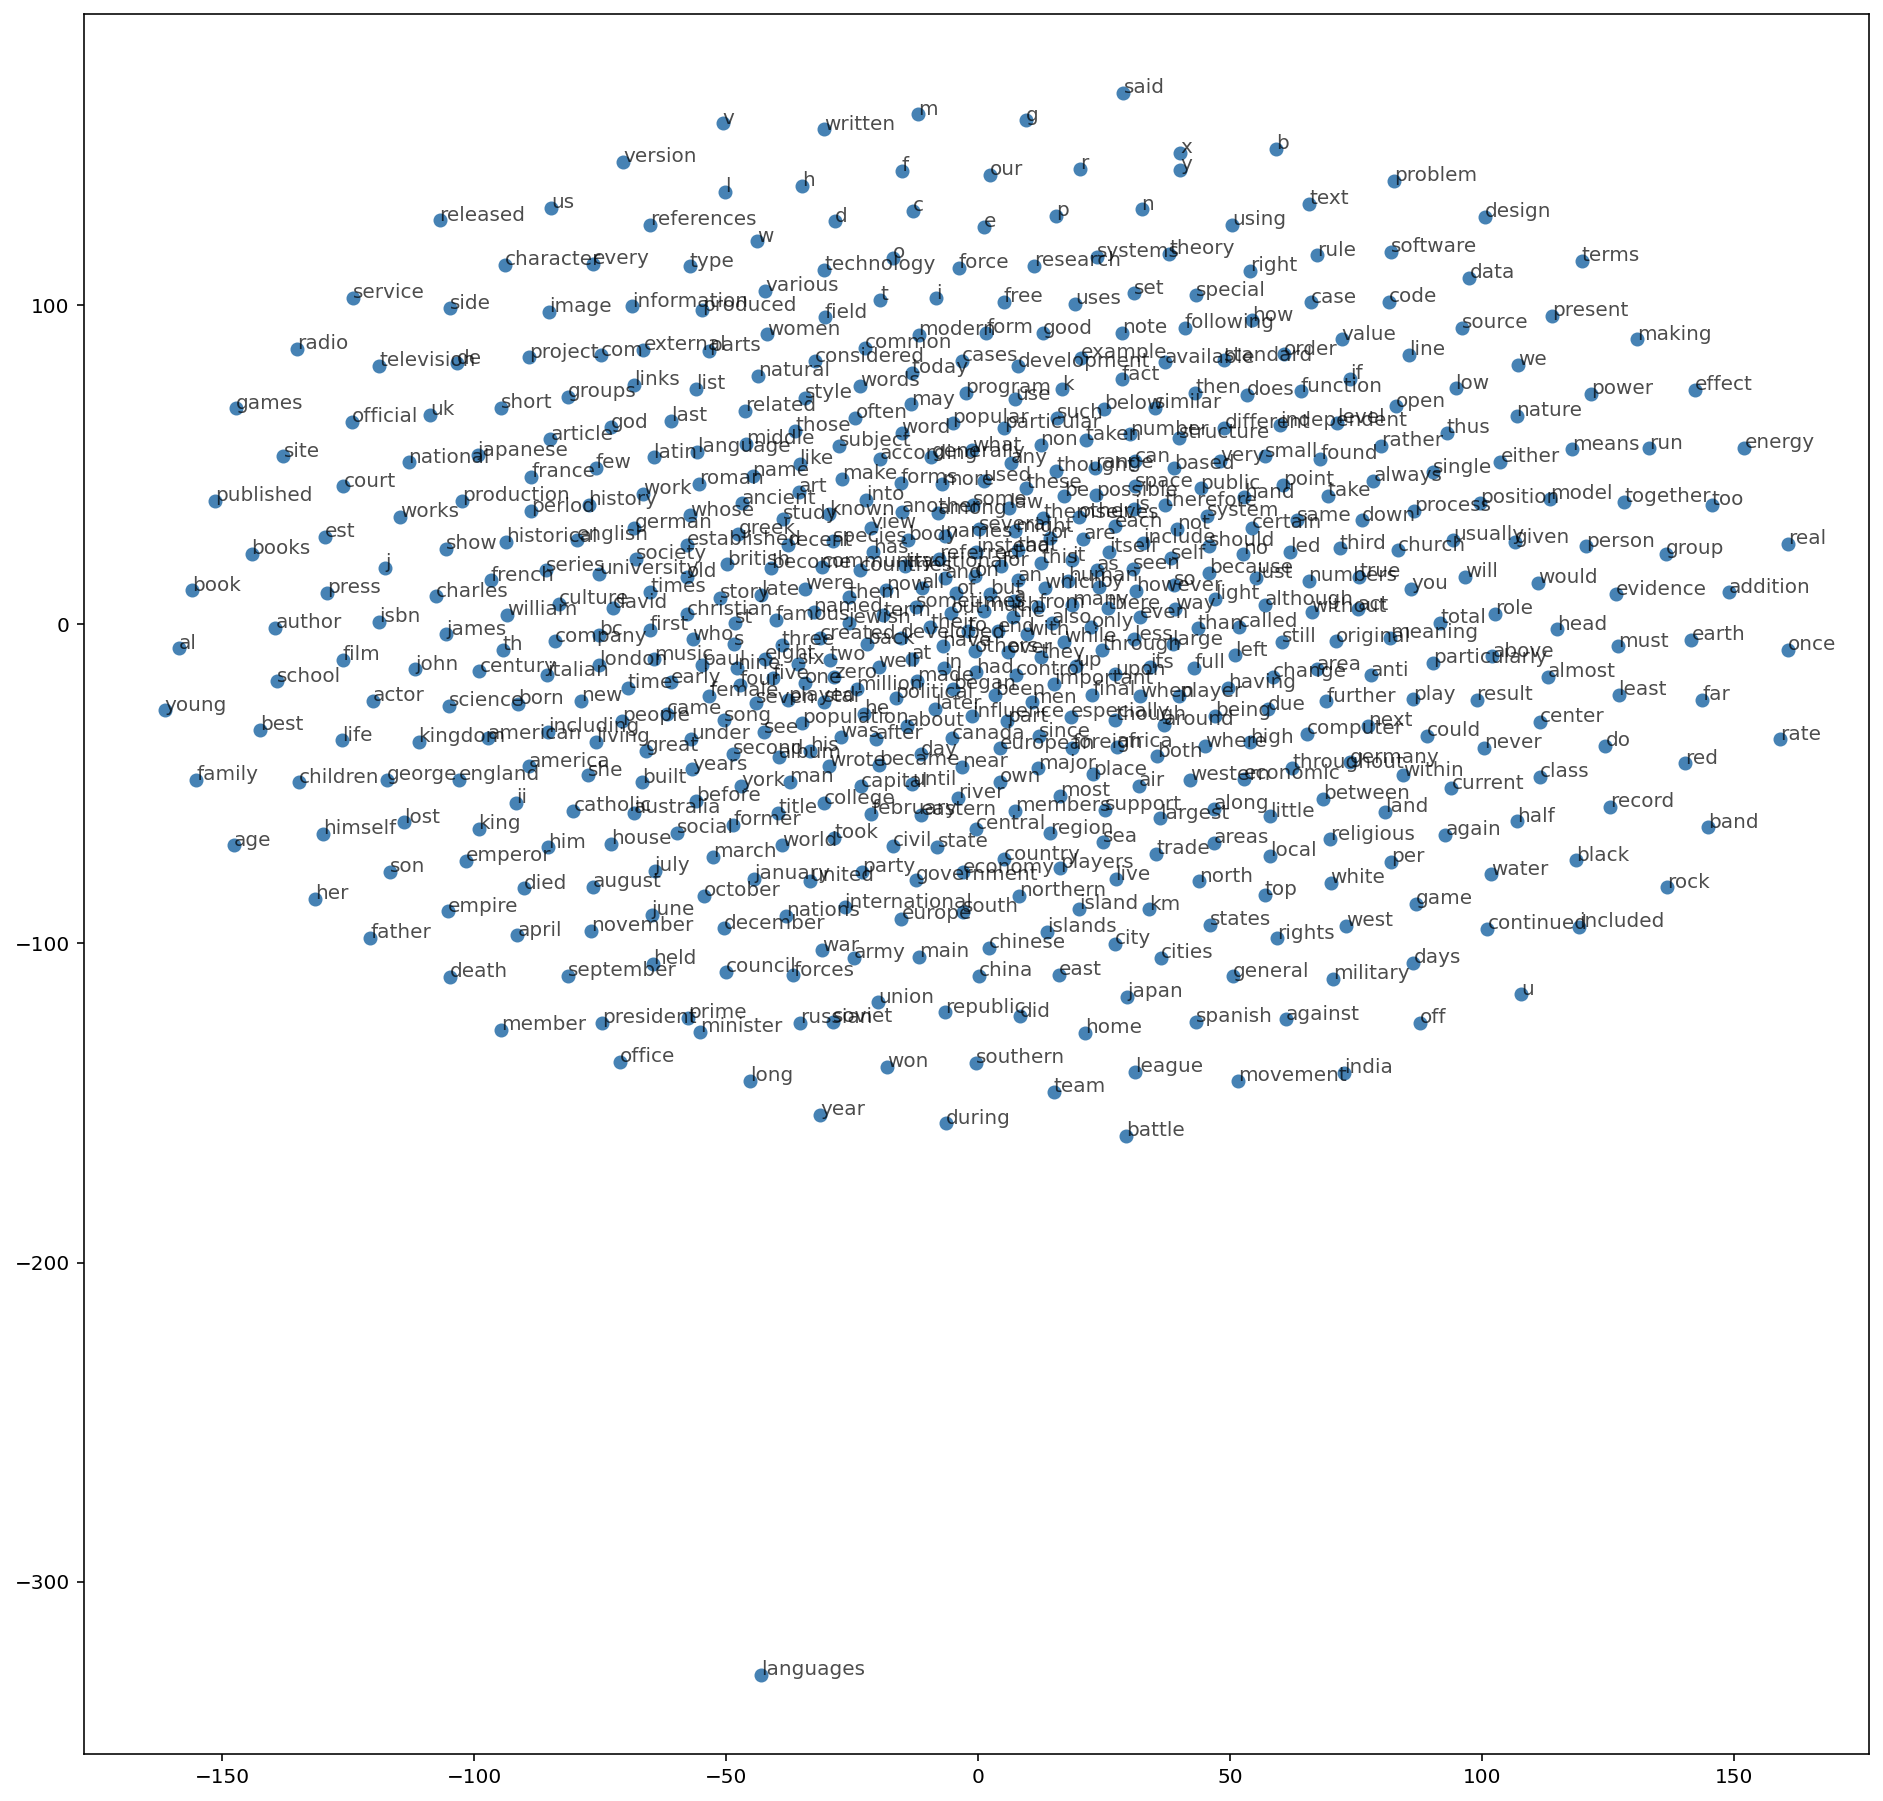

In [17]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)